In [ ]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout, Input, BatchNormalization,
    Conv1D, MaxPooling1D, Bidirectional, Flatten, Attention
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Hugging Face Datasets
from datasets import load_dataset

# NLTK
import nltk
from nltk.corpus import wordnet, stopwords

# Other Libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# NLTK Downloads
nltk.download('wordnet')
nltk.download('omw-1.4')


In [ ]:
# Dataset load
dataset = load_dataset("imdb")
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']


In [3]:
# Dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
# Dataset examples
print(dataset['train'][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [4]:
# Split size
print(f"Train size: {len(dataset['train'])}")
print(f"Test size: {len(dataset['test'])}")
# Проверка типа и структуры
print(dataset['train'].features)


Train size: 25000
Test size: 25000
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [6]:
# Review lengths
train_texts = [example['text'] for example in dataset['train']]
text_lengths = [len(text.split()) for text in train_texts]

# Text length statistics
print("Average text length:", np.mean(text_lengths))
print("Median text length:", np.median(text_lengths))
print("Maximum text length:", np.max(text_lengths))


Average text length: 233.7872
Median text length: 174.0
Maximum text length: 2470


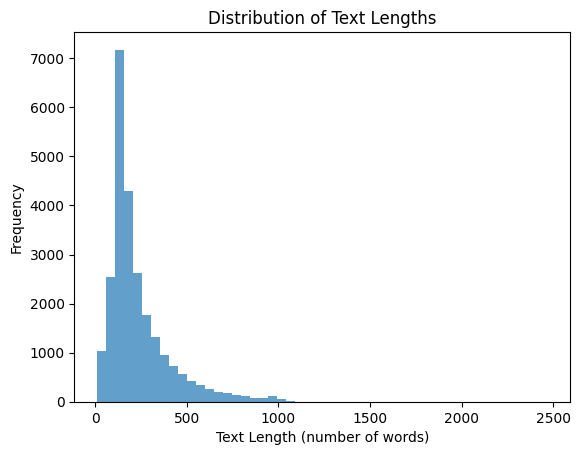

In [ ]:
# Distribution of text lengths
plt.hist(text_lengths, bins=50, alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length (number of words)")
plt.ylabel("Frequency")
plt.show()


[nltk_data] Downloading package stopwords to /home/viktar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


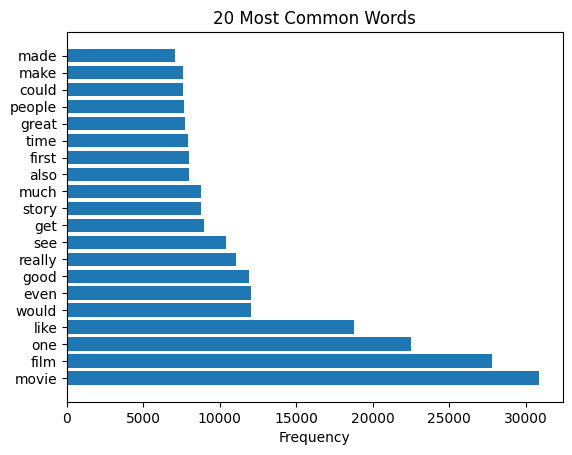

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenization and word counting
all_words = []
for text in train_texts:
    words = text.split()
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    all_words.extend(words)

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Visualization
words, counts = zip(*most_common_words)
plt.barh(words, counts)
plt.title("20 Most Common Words")
plt.xlabel("Frequency")
plt.show()


In [11]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# SVM training
svm_model = LinearSVC()
svm_model.fit(X_train, train_labels)

# Predictions and metrics
predictions = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(test_labels, predictions))


Accuracy: 0.86008


In [ ]:
# Loading the IMDb dataset
dataset = load_dataset("imdb")
train_texts = dataset['train']['text']
train_labels = np.array(dataset['train']['label'])  # Convert to NumPy array
test_texts = dataset['test']['text']
test_labels = np.array(dataset['test']['label'])  # Convert to NumPy array

# Data augmentation: synonym replacement
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)

    num_replacements = min(n, len(random_word_list))
    for random_word in random_word_list[:num_replacements]:
        synonyms = wordnet.synsets(random_word)
        synonym = random.choice(synonyms).lemmas()[0].name() if synonyms else random_word
        new_words = [synonym if word == random_word else word for word in new_words]
    return " ".join(new_words)

augmented_texts = [synonym_replacement(text, n=2) for text in train_texts[:1000]]  # Augment 1000 texts
augmented_labels = train_labels[:1000]

# Combine original and augmented data
train_texts = np.concatenate([train_texts, augmented_texts])
train_labels = np.concatenate([train_labels, augmented_labels])

# Improved text preprocessing
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)
X_train = pad_sequences(X_train, maxlen=200)
X_test = pad_sequences(X_test, maxlen=200)


2025-01-06 18:54:44.066840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736186084.161555     781 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736186084.182487     781 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 18:54:44.380926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package wordnet to /home/viktar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nl

In [13]:
# Building a model with increased number of neurons
input_layer = Input(shape=(200,))
embedding_layer = Embedding(input_dim=20000, output_dim=80, input_length=200)(input_layer)
lstm_out = LSTM(80, return_sequences=True)(embedding_layer)  

# Attention mechanism
attention_out = Attention()([lstm_out, lstm_out])
flatten_out = Flatten()(attention_out) 
dense_layer = Dense(80, activation='relu')(flatten_out) 
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Creating the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compiling the model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Training the model
history = model.fit(X_train, train_labels, validation_data=(X_test, test_labels), epochs=1, batch_size=64)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, test_labels)
print("Test Accuracy:", accuracy)


/home/viktar/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1736186873.644327     781 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1736186875.776819    4489 cuda_dnn.cc:529] Loaded cuDNN version 90501


407/407 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6534 - loss: 0.5846 - val_accuracy: 0.8258 - val_loss: 0.3780
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7668 - loss: 0.4709
Test Accuracy: 0.825760006904602


In [12]:
# Loading the IMDb dataset
dataset = load_dataset("imdb")
data_copy = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas()

# Data preprocessing
data_copy['sentiment'] = data_copy['label'].apply(lambda x: "positive" if x == 1 else "negative")
test_data['sentiment'] = test_data['label'].apply(lambda x: "positive" if x == 1 else "negative")

# Text cleaning (keeping only preprocessing)
def clean_text(text, lemmatize=False):
    return text.lower()

data_copy['review'] = data_copy['text'].apply(clean_text)
test_data['review'] = test_data['text'].apply(clean_text)

# Converting labels
data_copy.sentiment = [1 if each == "positive" else 0 for each in data_copy.sentiment]
test_data.sentiment = [1 if each == "positive" else 0 for each in test_data.sentiment]

# Splitting into training and testing data
train, test = train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

# Tokenization
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
print("Vocabulary of the dataset is:", len(word_index))

# Creating sequences
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test = tokenizer.texts_to_sequences(Xtest)

# Sequence length
seq_len_list = [len(i) for i in seq_train + seq_test]
max_seq_len = int(np.mean(seq_len_list) + 2 * np.std(seq_len_list))
print('Max sequence length (2 std from mean):', max_seq_len)

# Creating padding
pad_train = pad_sequences(seq_train, truncating='post', padding='pre', maxlen=max_seq_len)
pad_test = pad_sequences(seq_test, truncating='post', padding='pre', maxlen=max_seq_len)

# Splitting training data for validation
Xtrain, Xval, ytrain, yval = train_test_split(pad_train, ytrain, test_size=0.2, random_state=10)


Vocabulary of the dataset is: 80148
Max sequence length (2 std from mean): 590


In [14]:
# Training curve plot
def plotLearningCurve(history, epochs):
    epochRange = range(1, epochs + 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(epochRange, history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(epochRange, history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange, history.history['loss'], label='Training Loss')
    ax[1].plot(epochRange, history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    fig.tight_layout()
    plt.show()


----Building the model----
----Training the network----
Epoch 1/10
250/250 - 20s - 80ms/step - accuracy: 0.5248 - loss: 1.4260 - val_accuracy: 0.5095 - val_loss: 0.7170 - learning_rate: 5.0000e-04
Epoch 2/10
250/250 - 17s - 70ms/step - accuracy: 0.5832 - loss: 0.6892 - val_accuracy: 0.6850 - val_loss: 0.6907 - learning_rate: 5.0000e-04
Epoch 3/10
250/250 - 19s - 77ms/step - accuracy: 0.7090 - loss: 0.5790 - val_accuracy: 0.7785 - val_loss: 0.5076 - learning_rate: 5.0000e-04
Epoch 4/10
250/250 - 19s - 77ms/step - accuracy: 0.8149 - loss: 0.4323 - val_accuracy: 0.8640 - val_loss: 0.3511 - learning_rate: 5.0000e-04
Epoch 5/10
250/250 - 20s - 79ms/step - accuracy: 0.8686 - loss: 0.3221 - val_accuracy: 0.8763 - val_loss: 0.3052 - learning_rate: 5.0000e-04
Epoch 6/10
250/250 - 20s - 79ms/step - accuracy: 0.8938 - loss: 0.2688 - val_accuracy: 0.8810 - val_loss: 0.3007 - learning_rate: 5.0000e-04
Epoch 7/10
250/250 - 20s - 79ms/step - accuracy: 0.9155 - loss: 0.2265 - val_accuracy: 0.8835 - va

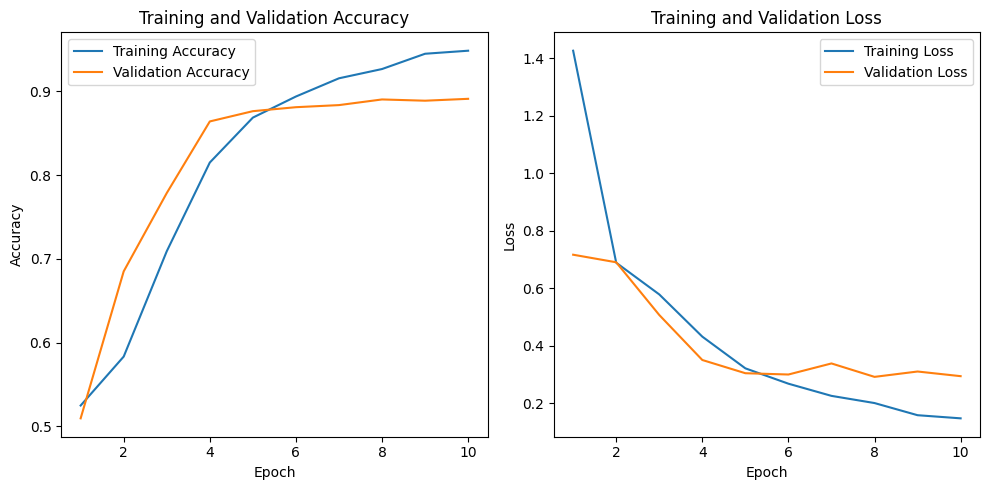

Evaluate Model Performance on Test set
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8942 - loss: 0.2887
{'loss': 0.29666364192962646, 'compile_metrics': 0.8881999850273132}


In [16]:
# Building the LSTM model
def lstm_model(Xtrain, Xval, ytrain, yval, V, D, maxlen, epochs):
    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D, input_length=maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32, 5, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = LSTM(350, kernel_regularizer=l2(0.01))(x)  # L2 regularization
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    #model.summary()

    print("----Training the network----")
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    r = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=epochs, verbose=2, batch_size=64, callbacks=[lr_callback])
    print("Train score:", model.evaluate(Xtrain, ytrain))
    print("Validation score:", model.evaluate(Xval, yval))
    n_epochs = len(r.history['loss'])
    return r, model, n_epochs

# Model parameters
D = 64  # embedding dimensions
epochs = 10

# Start training
r, model, n_epochs = lstm_model(Xtrain, Xval, ytrain, yval, len(word_index), D, max_seq_len, epochs)

# Training curves
plotLearningCurve(r, n_epochs)

# Evaluation on the test set
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test, ytest)
print(dict(zip(model.metrics_names, result)))


Epoch 1/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6600 - loss: 0.5984 - val_accuracy: 0.8491 - val_loss: 0.3560
Epoch 2/2
407/407 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8926 - loss: 0.2719 - val_accuracy: 0.8636 - val_loss: 0.3427
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8230 - loss: 0.4449
Test Accuracy: 0.8636400103569031


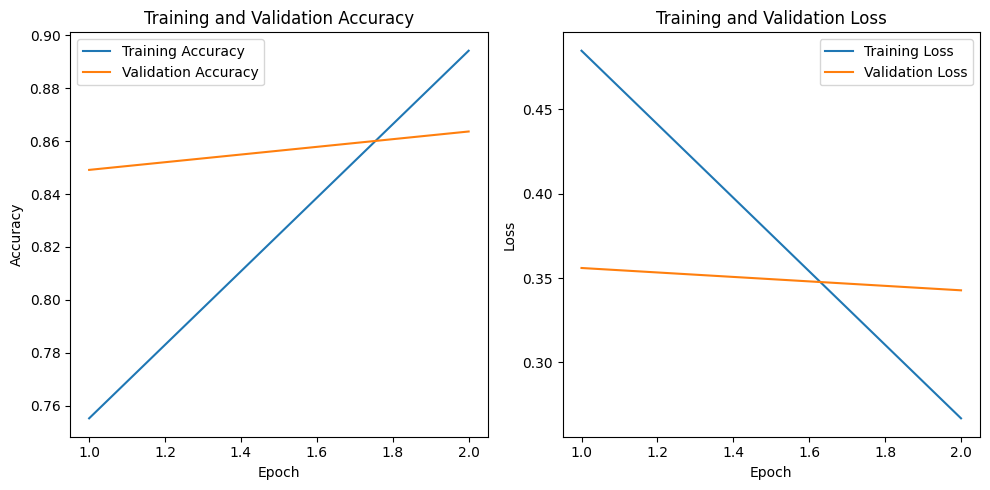

In [15]:
# Creating the GRU model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
n_epochs = 2
# Training the model
history = model.fit(X_train, train_labels, validation_data=(X_test, test_labels), epochs=n_epochs, batch_size=64)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, test_labels)
print("Test Accuracy:", accuracy)

# Correct call to plotLearningCurve
plotLearningCurve(history, n_epochs)
